# Data Analysis and Charting

```
Dustin Michels
November 2017
```

## Reading Data

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import parallel_coordinates

In [2]:
data_path = '../../data/'
go_data_path = data_path + 'go_downloads/'
img_path = '../imgs/'

### Read Metadata CSV

In [3]:
# Get and clean project meta data
meta_df = pd.read_csv(data_path + "project_metadata_functional.csv")

# Make column names neater
meta_df.columns = meta_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.lower()
meta_df.columns = meta_df.columns.str.replace(' ', '_')
meta_df.rename(columns={'sample_details':'zone'}, inplace=True)

# Split lat and long into seperate columns
meta_df['lat'] = meta_df['lat/long'].str.split(',', 1).str[0]
meta_df['long'] = meta_df['lat/long'].str.split(',', 1).str[1]

# Clean up 'region' and 'zone' columns
meta_df['region'] = meta_df['region'].str.strip()
meta_df['zone'] = meta_df['zone'].str.strip()

# Indicate categorical data
meta_df['region'] = meta_df['region'].astype('category')
meta_df['zone'] = meta_df['zone'].astype('category')
meta_df['run_id'] = meta_df['run_id'].astype('category')

# Drop a few categories
meta_df.drop(
    ['downloaded','link_to_info', 'student', 'lat/long'],
    axis=1, inplace=True)

# Display first few items
display("Metadata (Head):", meta_df.head())

'Metadata (Head):'

,region,run_id,filename,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
0,Southern Ocean (near Antarctica),ERR599104,ERR599104_MERGED_FASTQ_GO.csv,deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
1,Southern Ocean (near Antarctica),ERR599090,ERR599090_MERGED_FASTQ_GO.csv,surface water layer,5,0.67108,0.065273,27.501159,343.437300,34.353880,-62.0385,-49.5290
2,Southern Ocean (near Antarctica),ERR599008,ERR599008_MERGED_FASTQ_GO.csv,mesopelagic zone,790,0.45883,0.010087,38.821249,203.839400,34.679960,-61.9689,-49.5017
3,South Pacific (near the Marquesas),ERR598948,ERR598948_MERGED_FASTQ_GO.csv,deep chlorophyll maximum layer,115,24.69625,0.295808,2.333576,179.916875,36.097575,-9.0063,-139.1394
4,South Pacific (near the Marquesas),ERR598992,ERR598992_MERGED_FASTQ_GO.csv,surface water layer,5,26.54413,0.166512,3.986359,186.240700,35.366200,-8.9971,-139.1963


### Read GO Annotation CSVs

In [4]:
def get_df(idx):
    """Helper function for parsing CSVs"""
    
    filenames = meta_df['filename']
    names = ['go_id', 'name', 'namespace', 'read_count']

    # Read GO csv (for given index)
    filepath = f"{go_data_path}{filenames[idx]}"
    df = pd.read_csv(
        filepath, header=None, names=names)
    
    # Add run_id column
    df.insert(0, 'run_id', meta_df['run_id'][idx])
    
    # Sort by read_count
    df.sort_values('read_count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Add read_percent column, based on read_count
    read_sum = df['read_count'].sum()
    df['read_percent'] = (df['read_count']/read_sum)
    
    # Drop some columns
    df.drop(['go_id','read_count'], axis=1, inplace=True)
    
    return df

# Call helper function with all GO annotations,
# concatenating resulting dataframes together
df = get_df(0)
for i in range(1, len(meta_df)):
    new_df = get_df(i)
    df = pd.concat([df, new_df])
df.reset_index(drop=True, inplace=True)
    
# Indicate categorical data
df['run_id'] = df['run_id'].astype('category')
df['namespace'] = df['namespace'].astype('category')

# Display
display("GO Annotations (head & tail):", df.head(), df.tail())

'GO Annotations (head & tail):'

,run_id,name,namespace,read_percent
0,ERR599104,catalytic activity,molecular_function,0.066795
1,ERR599104,oxidation-reduction process,biological_process,0.058572
2,ERR599104,ATP binding,molecular_function,0.054929
3,ERR599104,metabolic process,biological_process,0.040067
4,ERR599104,membrane,cellular_component,0.031069


,run_id,name,namespace,read_percent
24086,ERR599031,vesicle docking involved in exocytosis,biological_process,6.473864e-08
24087,ERR599031,mitochondrial pyruvate transport,biological_process,6.473864e-08
24088,ERR599031,galactosylceramide catabolic process,biological_process,6.473864e-08
24089,ERR599031,glycerol ether metabolic process,biological_process,6.473864e-08
24090,ERR599031,cutinase activity,molecular_function,6.473864e-08


### Merge the Two DataFrames Together

In [5]:
# Merge, using run_id
full_df = df.merge(meta_df)
full_df.drop('filename', axis=1, inplace=True)

display('Full DataFrame (head & tail):', full_df.head(), full_df.tail())

'Full DataFrame (head & tail):'

,run_id,name,namespace,read_percent,region,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
0,ERR599104,catalytic activity,molecular_function,0.066795,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
1,ERR599104,oxidation-reduction process,biological_process,0.058572,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
2,ERR599104,ATP binding,molecular_function,0.054929,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
3,ERR599104,metabolic process,biological_process,0.040067,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139
4,ERR599104,membrane,cellular_component,0.031069,Southern Ocean (near Antarctica),deep chlorophyll maximum layer,90,-0.78154,0.540091,33.109231,325.402987,34.319478,-62.2231,-49.2139


,run_id,name,namespace,read_percent,region,zone,depth_(m),temp_(c),chlorophyl_(mg_chl/m3),nitrate_(µmol/l),oxygen_(µmol/kg),salinity_(psu),lat,long
24086,ERR599031,vesicle docking involved in exocytosis,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24087,ERR599031,mitochondrial pyruvate transport,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24088,ERR599031,galactosylceramide catabolic process,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24089,ERR599031,glycerol ether metabolic process,biological_process,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851
24090,ERR599031,cutinase activity,molecular_function,6.473864e-08,Arabian Sea,mesopelagic zone,600,12.066048,0.005649,31.802451,1.63999,35.693546,20.8457,63.5851


## Make Heat & Cluster Maps

### Further data processing

In [6]:
## Get superset of 25 most abundant groups shared
## by all samples. This becomes 29 functional groups.

grouped_df = full_df.groupby('run_id').head(n=25)
names = grouped_df.name.unique()

# Select entries in full_df where name is one of the 29
df = full_df[full_df.name.isin(names)]

# Make a deep copy (instead of using a slice of full_df)
df = df.copy(deep=True)

In [7]:
# Truncate function names at 35 characters
df.name = df.name.apply(
    lambda x: (x[:35] + '...') if len(x) > 38 else x)

In [8]:
## Rearranage data so it's ready for heat map visualization

# data_all: Rearrange/clean data for all samples
data_all = df.pivot(
    index='name', columns='run_id',
    values='read_percent')
data_all.columns.name = 'Run ID'
data_all.index.name = "Functional Category Name"

# data_region: Rearrange/clean data, taking mean of regions
data_region = df.pivot_table(
    index='name', columns='region',
    aggfunc={'read_percent':'mean'})
data_region.columns = data_region.columns.droplevel(0)
data_region.columns.name = 'Region'
data_region.index.name = "Functional Category Name"

# data_zone: Rearrange/clean data, taking mean of zones
data_zone = df.pivot_table(
    index='name', columns='zone',
    aggfunc={'read_percent':'mean'})
data_zone.columns = data_zone.columns.droplevel(0)
data_zone.columns.name = 'Zone'
data_zone.index.name = "Functional Category Name"

In [9]:
# Show what data looks like now
display('data_all (head)', data_all.head())
display('data_region (head)', data_region.head())
display('data_zone (head)', data_zone.head())

'data_all (head)'

Run ID,ERR598948,ERR598980,ERR598992,ERR598995,ERR598999,ERR599008,ERR599031,ERR599078,ERR599090,ERR599104,ERR599142
Functional Category Name,,,,,,,,,,,
ATP binding,0.054676,0.051896,0.056190,0.056112,0.052368,0.051243,0.051192,0.056278,0.054078,0.054929,0.057116
ATPase activity,0.005978,0.006241,0.005844,0.006044,0.006248,0.006768,0.005694,0.006379,0.005709,0.006088,0.005991
DNA binding,0.020949,0.019473,0.020239,0.021562,0.020241,0.020993,0.022989,0.020380,0.019620,0.019859,0.019743
DNA replication,0.005743,0.004795,0.005770,0.007172,0.004759,0.004741,0.004805,0.005784,0.005067,0.005243,0.005490
GTP binding,0.006697,0.006632,0.007168,0.006722,0.006666,0.006579,0.006832,0.007035,0.006799,0.006981,0.007332


'data_region (head)'

Region,Arabian Sea,North Atlantic (off the coast of Portugal),North Pacific,South Pacific (near the Marquesas),Southern Ocean (near Antarctica)
Functional Category Name,,,,,
ATP binding,0.051192,0.056278,0.055041,0.054411,0.053416
ATPase activity,0.005694,0.006379,0.006092,0.006023,0.006188
DNA binding,0.022989,0.020380,0.020260,0.020477,0.020157
DNA replication,0.004805,0.005784,0.005819,0.005424,0.005017
GTP binding,0.006832,0.007035,0.006895,0.006844,0.006786


'data_zone (head)'

Zone,deep chlorophyll maximum layer,mesopelagic zone,surface water layer
Functional Category Name,,,
ATP binding,0.055239,0.051674,0.055915
ATPase activity,0.006037,0.006238,0.005981
DNA binding,0.020790,0.020924,0.019995
DNA replication,0.006053,0.004775,0.005528
GTP binding,0.006800,0.006677,0.007083


### Heat and cluster maps for all samples

In [16]:
data_all.head()

Run ID,ERR598948,ERR598980,ERR598992,ERR598995,ERR598999,ERR599008,ERR599031,ERR599078,ERR599090,ERR599104,ERR599142
Functional Category Name,,,,,,,,,,,
ATP binding,0.054676,0.051896,0.056190,0.056112,0.052368,0.051243,0.051192,0.056278,0.054078,0.054929,0.057116
ATPase activity,0.005978,0.006241,0.005844,0.006044,0.006248,0.006768,0.005694,0.006379,0.005709,0.006088,0.005991
DNA binding,0.020949,0.019473,0.020239,0.021562,0.020241,0.020993,0.022989,0.020380,0.019620,0.019859,0.019743
DNA replication,0.005743,0.004795,0.005770,0.007172,0.004759,0.004741,0.004805,0.005784,0.005067,0.005243,0.005490
GTP binding,0.006697,0.006632,0.007168,0.006722,0.006666,0.006579,0.006832,0.007035,0.006799,0.006981,0.007332


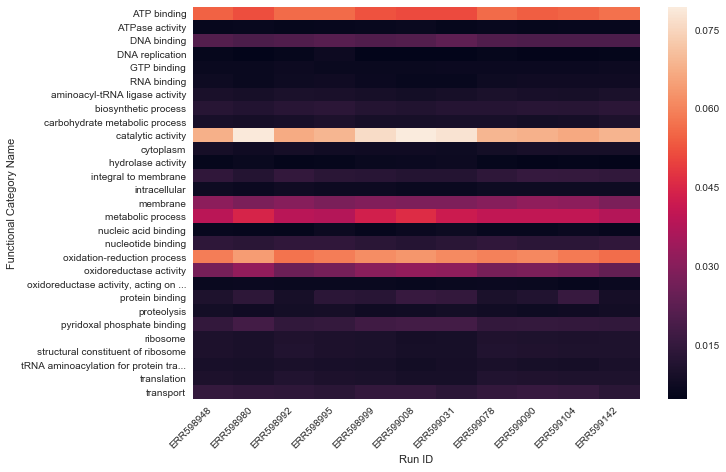

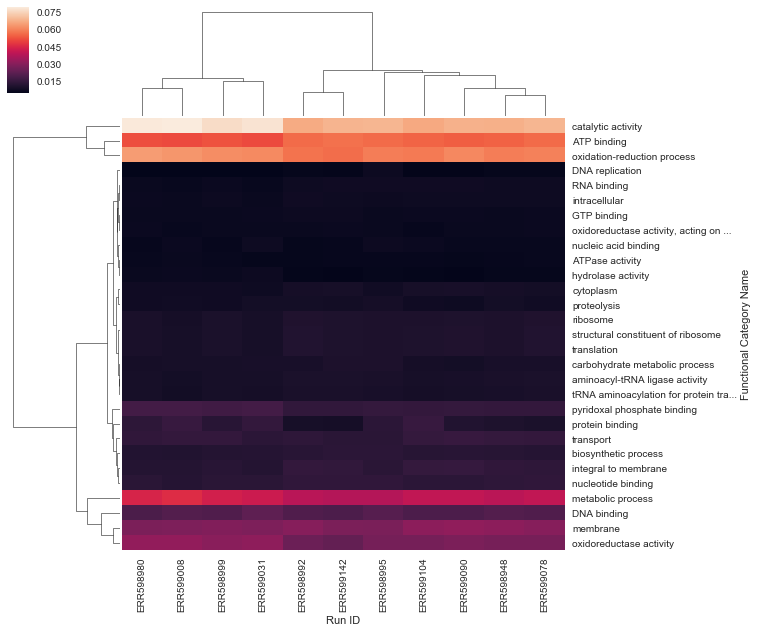

In [10]:
# Make heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ax=ax, data=data_all)
fig.autofmt_xdate(rotation=45)
fig.savefig(
    f'{img_path}heat/heat_all.png',
    bbox_inches='tight', dpi=300)

# Make clustermap
ax = sns.clustermap(data=data_all)
ax.savefig(
    f'{img_path}cluster/cluster_all',
    dpi=300)

### Heat and cluster maps, by region

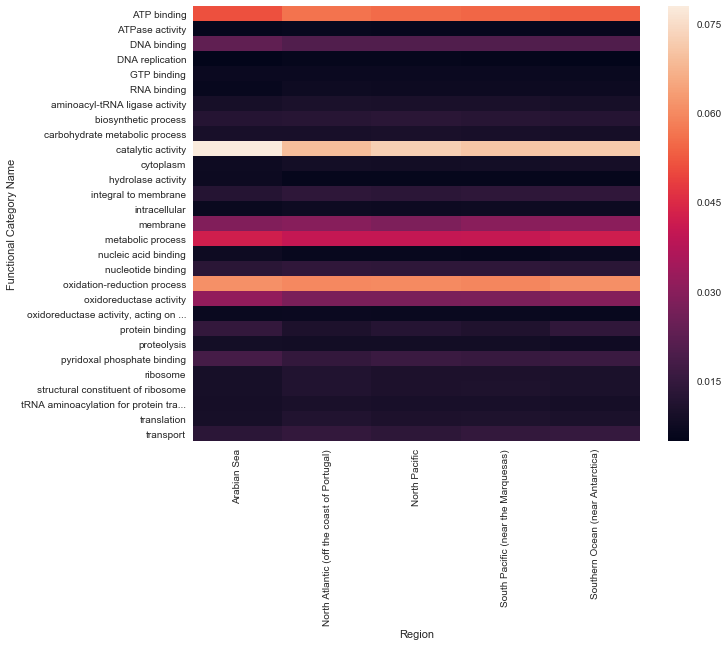

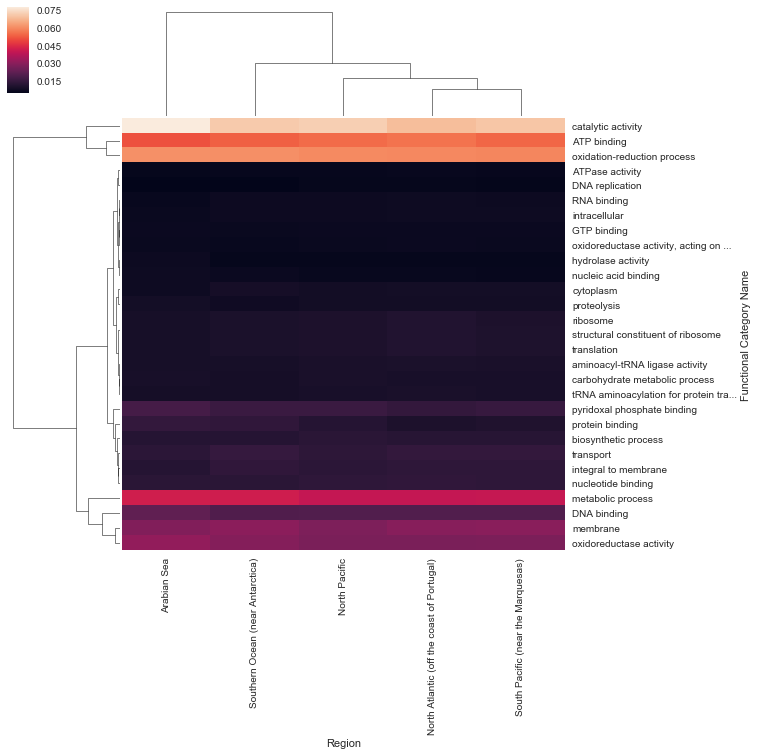

In [11]:
# Make heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ax=ax, data=data_region)
fig.savefig(
    f'{img_path}heat/heat_region.png',
    bbox_inches='tight', dpi=300)

# Make clustermap
ax = sns.clustermap(data=data_region)
ax.savefig(
    f'{img_path}cluster/cluster_region',
    dpi=300)

### Heat and cluster maps, by zone

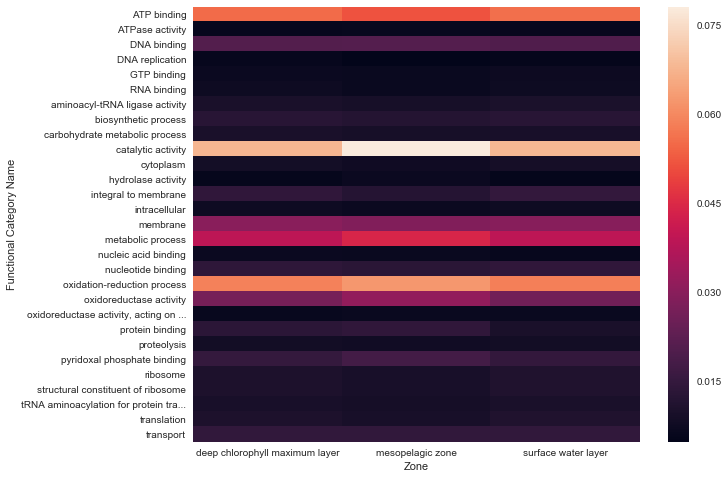

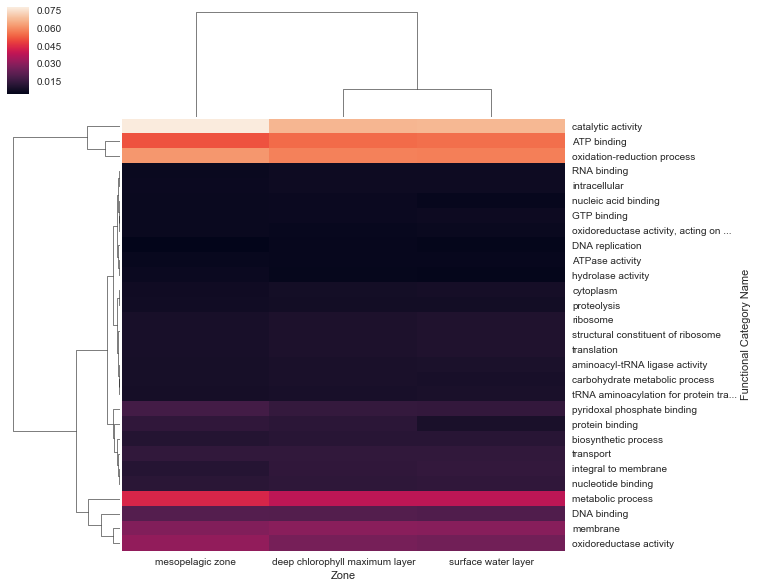

In [12]:
# Make heatmap
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ax=ax, data=data_zone)
fig.savefig(
    f'{img_path}/heat/heat_zone.png',
    bbox_inches='tight', dpi=300)

# Make clustermapi
ax = sns.clustermap(data=data_zone)
ax.savefig(
    f'{img_path}/cluster/cluster_zone',
    dpi=300)

### Heat maps, all grouped together

In [13]:
## Drop some labels

# data_all
data_all.index.name = "Functional Category Name"

# data_region
data_region.columns.name = 'Region'
data_region.index.name = None

# data_zone
data_zone.columns.name = 'Zone'
data_zone.index.name = None

/Users/dustymichels/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


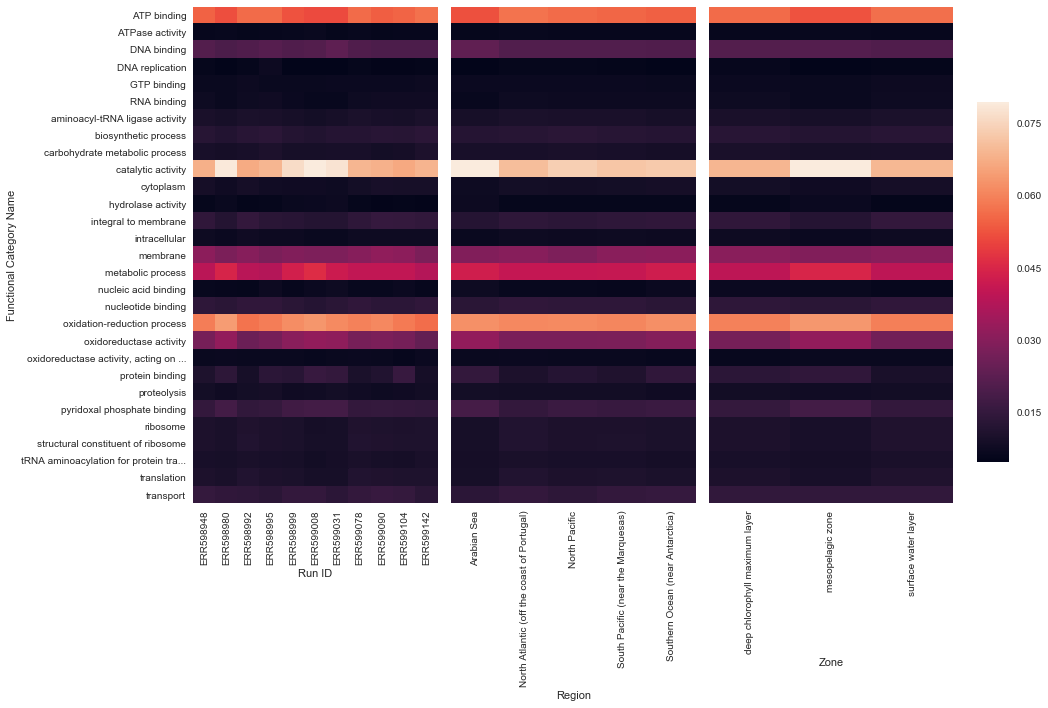

In [14]:
## Make sublots

fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, sharey=True, figsize=(15,10))

cbar_ax = fig.add_axes([.91, .35, .03, .5])

sns.heatmap(ax=ax1, data=data_all, cbar_ax=cbar_ax)
sns.heatmap(ax=ax2, data=data_region, cbar=None)
sns.heatmap(ax=ax3, data=data_zone, cbar=None)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(f'{img_path}/heat/heat_group.png', bbox_inches='tight', dpi=300)